In [ ]:
import tensorflow as tf
import numpy as np
matvec = tf.linalg.matvec
import matplotlib.pyplot as plt
import sklearn.model_selection
import glob

In [26]:
training_datasets_names = [
    'log_left_right',
    'log_forward_backward',
    'log_resting'
]

features = 6 # 3 directions for acceleration and 3 directions for rotation
duration = 50 # 1 second given the 20ms period
burnin = duration // 2

training_datasets_processed = []
training_datasets_y = []
for class_index, name in enumerate(training_datasets_names):
    array = np.concatenate([np.loadtxt(g)[:,:features] for g in glob.glob(name+'*')])
    print(f"Class {class_index} with {len(array)} samples.")
    # extract only the pertinent features from the log
    round_length = (len(array)//duration)*duration
    array = array[:round_length,:]
    array = array.reshape(-1,duration,features)
    training_datasets_processed.append(array)
    training_datasets_y.append(np.ones(len(array),dtype=int)*class_index)
x = np.concatenate(training_datasets_processed)
y = np.concatenate(training_datasets_y)

Class 0 with 12444 samples.
Class 1 with 7188 samples.
Class 2 with 6381 samples.


In [ ]:
x, xtest, y, ytest = sklearn.model_selection.train_test_split(x,y, test_size=0.1)

In [ ]:
x = x.transpose(1,2,0)
xtest = xtest.transpose(1,2,0)

In [ ]:
x.shape, x.dtype # axes in order: time, features, samples

In [ ]:
y.shape, y.dtype # axes in order: samples

In [ ]:
batchsize = len(y)

In [ ]:
x = tf.constant(x, dtype=tf.float32)
xtest = tf.constant(xtest, dtype=tf.float32)
y = tf.constant(y)
y_onehot = tf.one_hot(y,depth=len(training_datasets_names))
ytest = tf.constant(ytest)
ytest_onehot = tf.one_hot(ytest,depth=len(training_datasets_names))

In [ ]:
neurons_in = features

neurons_1s = 6
neurons_1o = 6
neurons_2s = 6
neurons_2o = 6

neurons_out = 3

W1s = tf.Variable(tf.random.normal((neurons_1s, neurons_in)))
U1  = tf.Variable(tf.random.normal((neurons_1s, neurons_1s)))
W1o = tf.Variable(tf.random.normal((neurons_1o, neurons_1s)))
B1s = tf.Variable(tf.random.normal((neurons_1s,1)))
B1o = tf.Variable(tf.random.normal((neurons_1o,1)))

W2s = tf.Variable(tf.random.normal((neurons_2s, neurons_1o)))
U2  = tf.Variable(tf.random.normal((neurons_2s, neurons_2s)))
W2o = tf.Variable(tf.random.normal((neurons_2o, neurons_2s)))
B2s = tf.Variable(tf.random.normal((neurons_2s,1)))
B2o = tf.Variable(tf.random.normal((neurons_2o,1)))

Wout = tf.Variable(tf.random.normal((neurons_out,neurons_1o)))
Bout = tf.Variable(tf.random.normal((neurons_out,)))

names = [
'W1s[neurons_1s*neurons_in]',
'U1 [neurons_1s*neurons_1s]',
'W1o[neurons_1o*neurons_1s]',
'B1s[neurons_1s]',
'B1o[neurons_1o]',
'W2s[neurons_2s*neurons_1o]',
'U2 [neurons_2s*neurons_2s]',
'W2o[neurons_2o*neurons_2s]',
'B2s[neurons_2s]',
'B2o[neurons_2o]',
'Wout[neurons_out*neurons_1o]',
'Bout[neurons_out]'
]

variables = [W1s, U1, W1o, B1s, B1o,
             W2s, U2, W2o, B2s, B2o,
             Wout, Bout]

In [ ]:
@tf.function
def rnn_step(state, v_in, Ws, U, Bs, Wo, Bo):
    new_state = tf.nn.relu(Ws@state + U@v_in + Bs)
    v_out = tf.nn.relu(Wo@new_state+Bo)
    return new_state, v_out

In [ ]:
@tf.function
def model(x,
          W1s, U1, W1o, B1s, B1o,
          W2s, U2, W2o, B2s, B2o,
          Wout, Bout, initializer=tf.random.normal):
    _, v1_outs = \
    tf.scan(lambda state_vout, v_in: rnn_step(state_vout[0], v_in, W1s, U1, B1s, W1o, B1o),
            x,
            initializer = (initializer((neurons_1s,x.shape[2])), x[0,...])
           )
    _, v2_outs = \
    tf.scan(lambda state_vout, v_in: rnn_step(state_vout[0], v_in, W2s, U2, B2s, W2o, B2o),
            v1_outs,
            initializer = (initializer((neurons_2s,x.shape[2])), x[0,...])
           )

    y_model = tf.einsum('ij,TjS->TSi', Wout, v2_outs) + Bout
    y_model = tf.nn.softmax(y_model, axis=2)
    return y_model

In [ ]:
hist = []

In [ ]:
# opt = tf.keras.optimizers.Nadam(0.002) # for 200 steps with a zero initializer
#opt = tf.keras.optimizers.Nadam(0.0002) # for a bunch more
opt = tf.keras.optimizers.Nadam(0.0002) # now with random initializer

In [ ]:
for i in range(400):
    with tf.GradientTape() as tape:
        y_model = model(x,
                        W1s, U1, W1o, B1s, B1o,
                        W2s, U2, W2o, B2s, B2o,
                        Wout, Bout,
                        #initializer=tf.zeros,
                       )
        y_model = y_model[burnin:,:,:]
        err = tf.reduce_mean((y_model-y_onehot)**2)
        reg = tf.reduce_mean([tf.reduce_mean(tf.abs(_)) for _ in variables])
        total_loss = err+0.05*reg
    yt_model = model(xtest,
                     W1s, U1, W1o, B1s, B1o,
                     W2s, U2, W2o, B2s, B2o,
                     Wout, Bout)
    yt_model = yt_model[burnin:,:,:]
    yt_model_n = yt_model.numpy()
    ytest_onehot_n = ytest_onehot.numpy()
    accuracy = np.take_along_axis(np.expand_dims(ytest_onehot_n, axis=0),
                                  np.expand_dims(np.argmax(yt_model_n,axis=2),
                                                 axis=2),
                                  axis=2)
    accuracy = np.mean(accuracy)
    t = tf.reduce_mean((yt_model-ytest_onehot)**2)
    hist.append([err.numpy(),t.numpy(),1-accuracy,reg.numpy()])
    grads = tape.gradient(total_loss, variables)
    opt.apply_gradients(zip(grads, variables))
    print(f'\r {i}: {hist[-1]}     ',end='',flush=True)

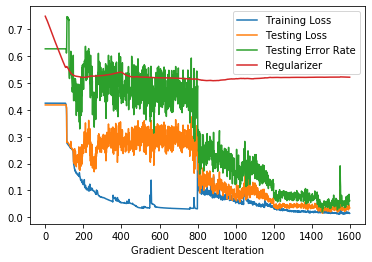

In [40]:
plt.plot(hist)
plt.legend(['Training Loss','Testing Loss','Testing Error Rate','Regularizer'])
plt.xlabel('Gradient Descent Iteration')
plt.savefig('training.png',dpi=300)

In [ ]:
np.set_printoptions(linewidth=1000,)

In [36]:
for n, a in zip(names,variables):
    s = ', '.join(map(str, a.numpy().flatten()))
    print(f'float {n} = {{ {s} }};')

float W1s[neurons_1s*neurons_in] = { 0.5321287, 0.6107104, 1.3286344, -0.6015093, 0.56184286, -0.050672613, -0.28946915, -0.57202274, 0.5797093, 0.10561681, 1.7290003, -0.68493843, -0.18255526, -0.37313738, 1.2256309, -0.1742842, 0.6492496, -0.16173245, -0.9695452, -0.5891188, -0.013323135, 0.6650615, 0.42116144, -0.59877527, 0.058546405, -0.71124023, -0.4949681, 0.026260667, 0.47205865, 0.017517323, 0.44564795, -0.76846886, 0.6713811, -1.7036608, 0.06296093, 0.27191502 };
float U1 [neurons_1s*neurons_1s] = { 0.08446167, 2.1222587, -0.262183, 0.041411262, 0.092383526, -1.0871025, 0.765727, -1.2816284, -0.79608244, 1.0392288, 0.05335982, 0.04486225, 0.046529382, -1.4757994, 0.13218978, 0.0464745, -0.06651882, -0.8113239, 2.010752, 0.27113342, -0.082562454, 0.36493123, -1.3630337, 1.5551832, -1.8181484, -0.21996354, -0.60703295, -0.20818894, 0.12968491, 1.1444167, -1.0321264, -0.71735334, -0.4447773, 0.25020576, 0.4118029, -1.9402288 };
float W1o[neurons_1o*neurons_1s] = { 0.13802966, -1

In [ ]:
np.savez('weights',*[a.numpy() for a in variables])